### Understanding speech domain
https://medium.com/@maftun.hashimli/basic-principles-of-speech-processing-d97dca031d38

https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53


brainstorm me ideas of approaching speech emotion recognition problem
ChatGPT


### Dataset citation

Livingstone SR, Russo FA (2018) The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391.



In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms
import torchvision.models as models
import torchaudio

In [2]:
# Folder path containing actor folders (update this with your local path)
archive_folder = "archive"

# Define the columns for the CSV
columns = ["File Path", "Modality", "Vocal Channel", "Emotion", "Emotional Intensity", "Statement", "Repetition", "Actor", "Gender"]

# Create an empty list to store the data
data = []

# Map for converting numbers to meaningful labels
modality_map = {"01": "full-AV", "02": "video-only", "03": "audio-only"}
vocal_channel_map = {"01": "speech", "02": "song"}
emotion_map = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}
intensity_map = {"01": "normal", "02": "strong"}
statement_map = {"01": "Kids are talking by the door", "02": "Dogs are sitting by the door"}

# Iterate through actor folders
for actor_folder in os.listdir(archive_folder):
    if actor_folder == '.DS_Store':
        continue
    actor_path = os.path.join(archive_folder, actor_folder)
    
    # Iterate through files within each actor's folder
    
    for file in os.listdir(actor_path):
        if file.endswith(".wav"):
            # Extract the 7 parts from the filename (without extension)
            parts = file.replace(".wav", "").split("-")
            
            # Extract details
            modality = modality_map.get(parts[0], "Unknown")
            vocal_channel = vocal_channel_map.get(parts[1], "Unknown")
            emotion = emotion_map.get(parts[2], "Unknown")
            intensity = intensity_map.get(parts[3], "Unknown")
            statement = statement_map.get(parts[4], "Unknown")
            repetition = parts[5]
            actor = parts[6]
            gender = "Male" if int(actor) % 2 != 0 else "Female"
            
            # Append the data
            data.append([os.path.join(actor_path, file), modality, vocal_channel, emotion, intensity, statement, repetition, actor, gender])

# Create a DataFrame
df = pd.DataFrame(data, columns=columns)

# Save to CSV
csv_path = "actor_files.csv"  
df.to_csv(csv_path, index=False)
df

,File Path,Modality,Vocal Channel,Emotion,Emotional Intensity,Statement,Repetition,Actor,Gender
0,archive/Actor_16/03-01-05-01-02-01-16.wav,audio-only,speech,angry,normal,Dogs are sitting by the door,01,16,Female
1,archive/Actor_16/03-01-06-01-02-02-16.wav,audio-only,speech,fearful,normal,Dogs are sitting by the door,02,16,Female
2,archive/Actor_16/03-01-06-02-01-02-16.wav,audio-only,speech,fearful,strong,Kids are talking by the door,02,16,Female
3,archive/Actor_16/03-01-05-02-01-01-16.wav,audio-only,speech,angry,strong,Kids are talking by the door,01,16,Female
4,archive/Actor_16/03-01-07-01-01-01-16.wav,audio-only,speech,disgust,normal,Kids are talking by the door,01,16,Female
...,...,...,...,...,...,...,...,...,...
1435,archive/Actor_08/03-01-03-02-02-02-08.wav,audio-only,speech,happy,strong,Dogs are sitting by the door,02,08,Female
1436,archive/Actor_08/03-01-03-01-01-02-08.wav,audio-only,speech,happy,normal,Kids are talking by the door,02,08,Female
1437,archive/Actor_08/03-01-02-02-01-01-08.wav,audio-only,speech,calm,strong,Kids are talking by the door,01,08,Female
1438,archive/Actor_08/03-01-02-01-02-01-08.wav,audio-only,speech,calm,normal,Dogs are sitting by the door,01,08,Female


### Gonna visualize mel spectogram of voices to better understand
filtering intensity so can get better understanding as loudness features wont be mixed between each class

In [3]:
csv_file = 'actor_files.csv'
df = pd.read_csv(csv_file)

df_filtered = df[df['Emotional Intensity'] == 'strong']

train_df, test_df = train_test_split(df_filtered, test_size=0.2, stratify=df_filtered[['Emotion', 'Gender']], random_state=42)

train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

len(train_df),len(test_df)

(537, 135)

In [4]:
train_df

,File Path,Modality,Vocal Channel,Emotion,Emotional Intensity,Statement,Repetition,Actor,Gender
1231,archive/Actor_07/03-01-08-02-02-02-07.wav,audio-only,speech,surprised,strong,Dogs are sitting by the door,2,7,Male
1329,archive/Actor_01/03-01-07-02-02-01-01.wav,audio-only,speech,disgust,strong,Dogs are sitting by the door,1,1,Male
1403,archive/Actor_08/03-01-07-02-02-02-08.wav,audio-only,speech,disgust,strong,Dogs are sitting by the door,2,8,Female
716,archive/Actor_05/03-01-07-02-01-01-05.wav,audio-only,speech,disgust,strong,Kids are talking by the door,1,5,Male
911,archive/Actor_24/03-01-07-02-01-01-24.wav,audio-only,speech,disgust,strong,Kids are talking by the door,1,24,Female
...,...,...,...,...,...,...,...,...,...
240,archive/Actor_21/03-01-08-02-01-01-21.wav,audio-only,speech,surprised,strong,Kids are talking by the door,1,21,Male
758,archive/Actor_12/03-01-04-02-02-01-12.wav,audio-only,speech,sad,strong,Dogs are sitting by the door,1,12,Female
302,archive/Actor_19/03-01-02-02-02-01-19.wav,audio-only,speech,calm,strong,Dogs are sitting by the door,1,19,Male
74,archive/Actor_11/03-01-08-02-02-01-11.wav,audio-only,speech,surprised,strong,Dogs are sitting by the door,1,11,Male


### Actor 1 Spectograms visualization

Processing: archive/Actor_01/03-01-08-02-02-01-01.wav


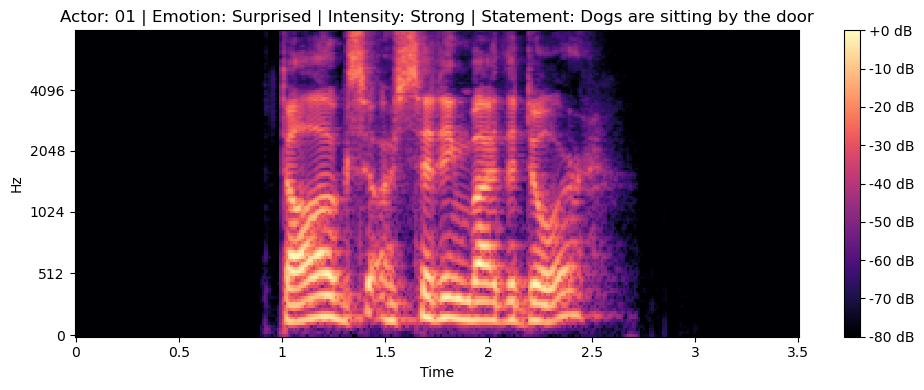

Processing: archive/Actor_01/03-01-05-02-01-01-01.wav


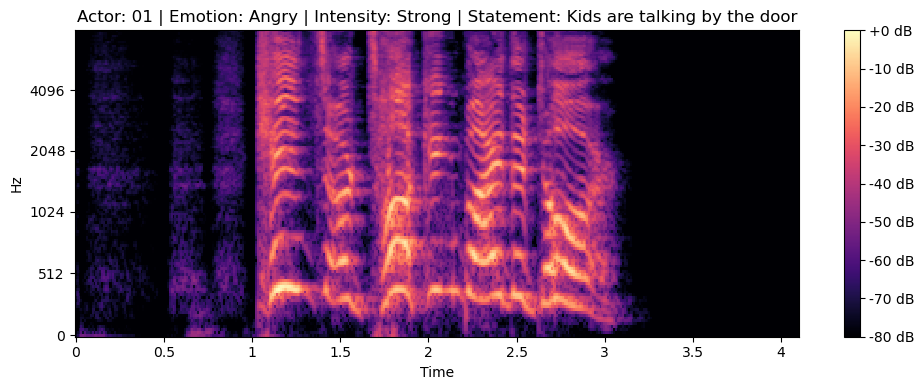

Processing: archive/Actor_01/03-01-07-02-02-01-01.wav


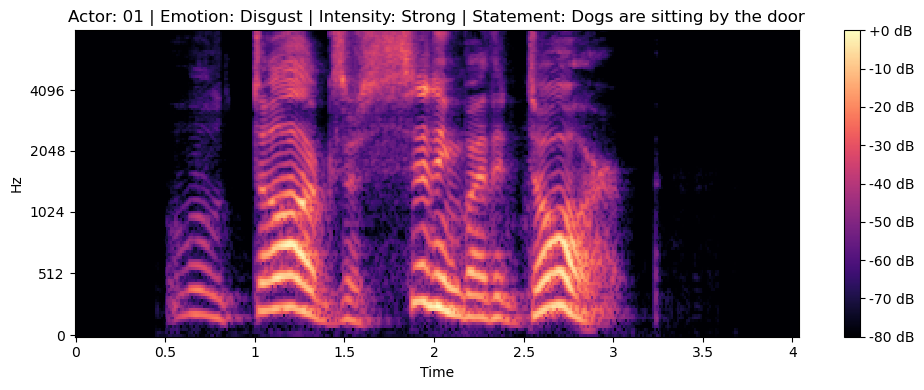

Processing: archive/Actor_01/03-01-02-02-01-01-01.wav


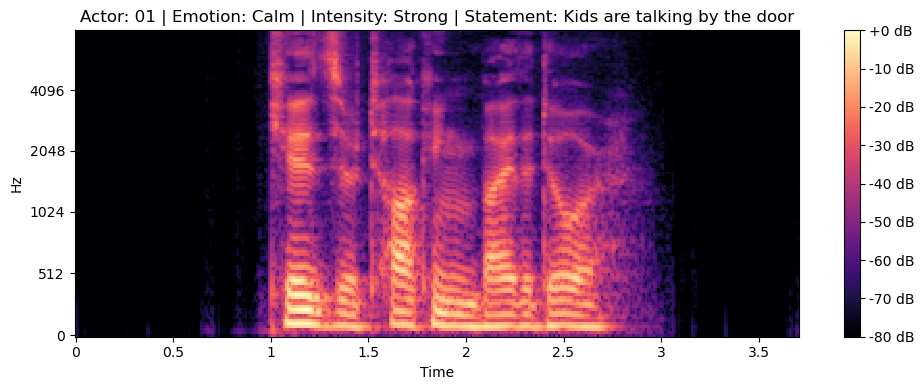

Processing: archive/Actor_01/03-01-03-02-01-01-01.wav


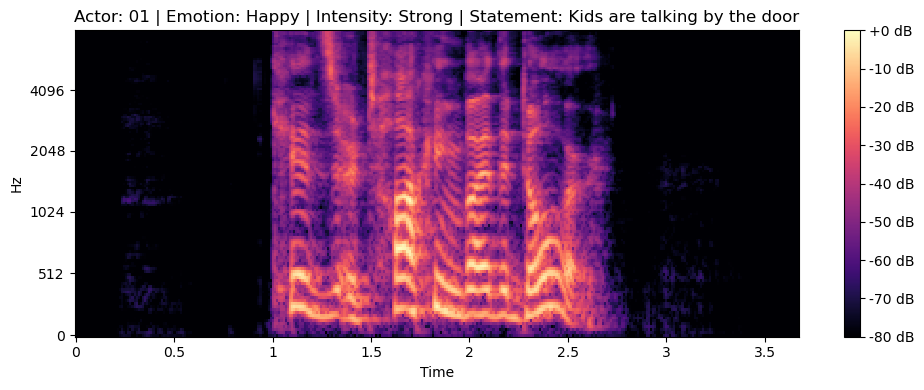

Processing: archive/Actor_01/03-01-06-02-02-01-01.wav


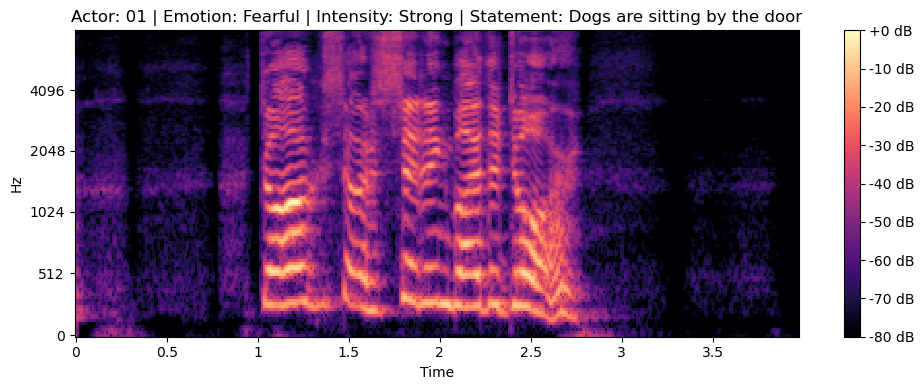

Processing: archive/Actor_01/03-01-04-02-01-01-01.wav


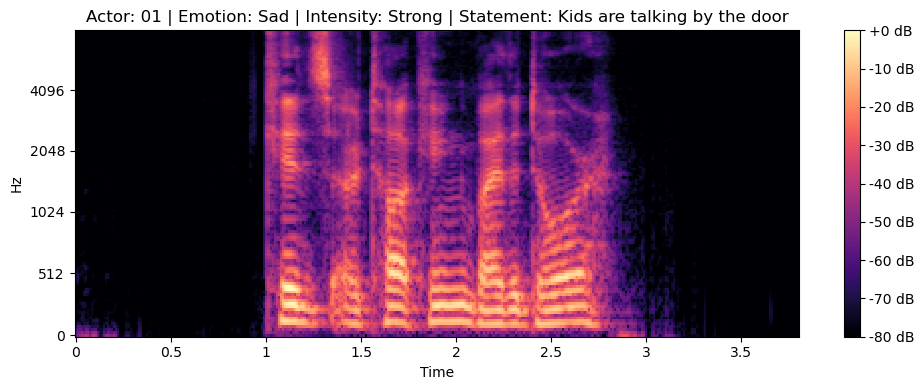

Processing: archive/Actor_01/03-01-03-02-02-01-01.wav


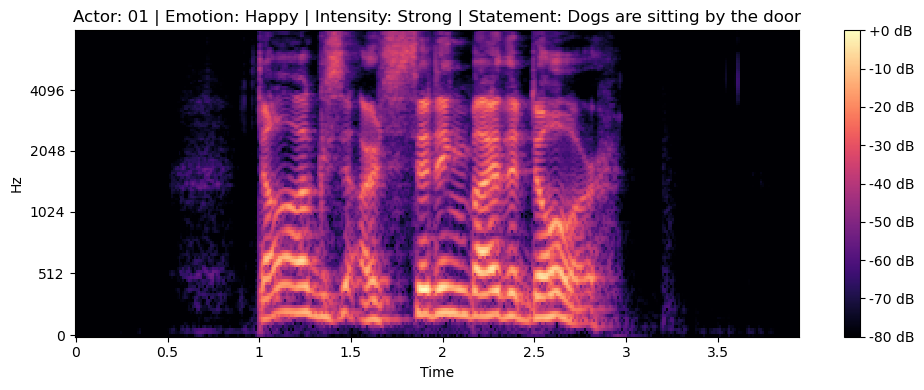

Processing: archive/Actor_01/03-01-04-02-02-01-01.wav


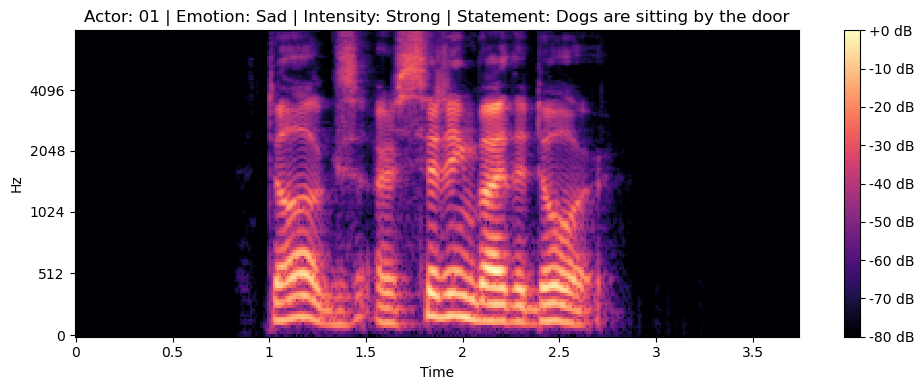

Processing: archive/Actor_01/03-01-06-02-01-01-01.wav


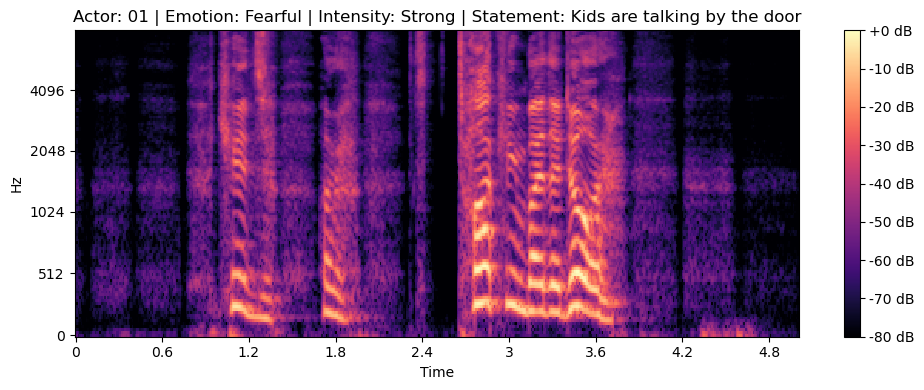

Processing: archive/Actor_01/03-01-08-02-01-01-01.wav


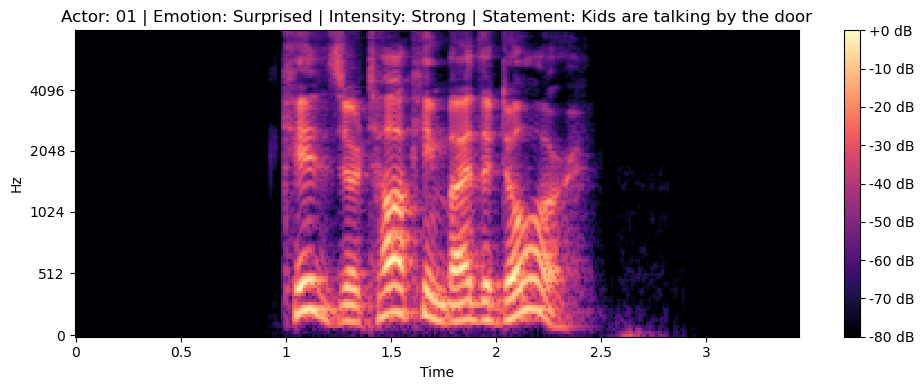

Processing: archive/Actor_01/03-01-07-02-01-01-01.wav


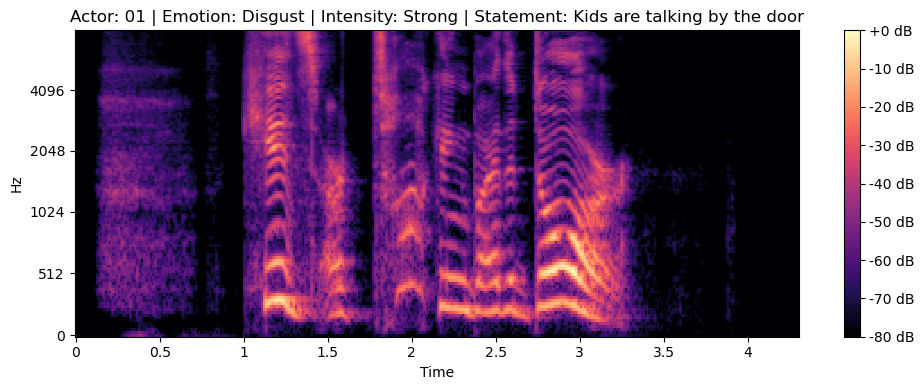

Processing: archive/Actor_01/03-01-05-02-02-01-01.wav


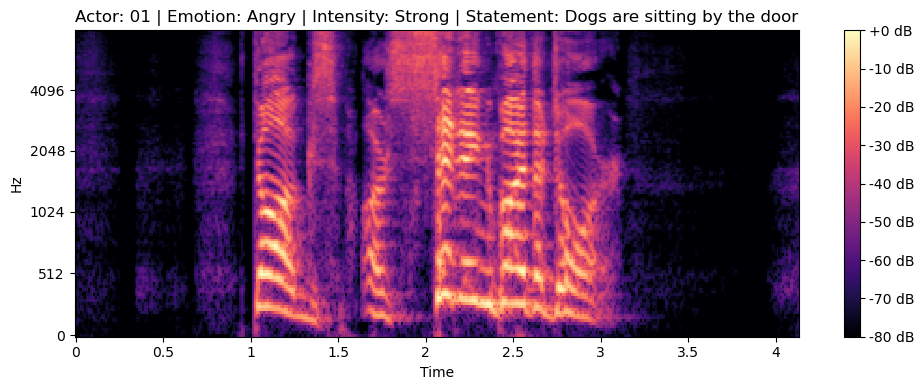

Processing: archive/Actor_01/03-01-02-02-02-01-01.wav


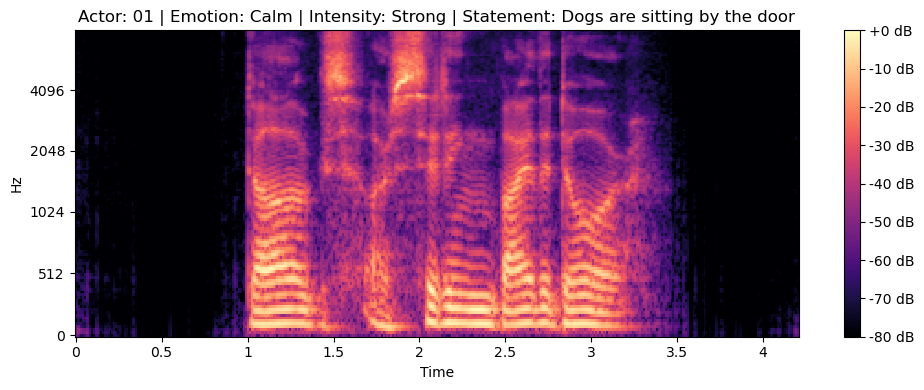

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# Function to decode the filename and extract labels
def extract_labels(filename):
    parts = filename.split('.')[0].split('-')
    labels = {
        'Gender': "Female" if int(parts[6]) % 2 ==0 else 'Male',
        'Modality': 'Full-AV' if parts[0] == '01' else 'Video-only' if parts[0] == '02' else 'Audio-only',
        'Vocal Channel': 'Speech' if parts[1] == '01' else 'Song',
        'Emotion': {
            '01': 'Neutral', '02': 'Calm', '03': 'Happy', '04': 'Sad', 
            '05': 'Angry', '06': 'Fearful', '07': 'Disgust', '08': 'Surprised'
        }[parts[2]],
        'Emotional Intensity': 'Normal' if parts[3] == '01' else 'Strong',
        'Statement': 'Kids are talking by the door' if parts[4] == '01' else 'Dogs are sitting by the door',
        'Repetition': parts[5],
        'Actor': parts[6]
    }
    return labels

# Function to plot the mel spectrogram
def plot_mel_spectrogram(audio_path, labels):
    try:
        y, sr = librosa.load(audio_path, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        S_db = librosa.power_to_db(S, ref=np.max)

        # Plotting
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        
        # Add title with extracted labels
        title = f"Actor: {labels['Actor']} | Emotion: {labels['Emotion']} | Intensity: {labels['Emotional Intensity']} | Statement: {labels['Statement']}"
        plt.title(title)
        
        plt.tight_layout()
        plt.show()  # Show the plot interactively

    except Exception as e:
        print(f"Error loading or plotting {audio_path}: {e}")

# Directory for Actor 01
actor_folder = 'archive/Actor_01'

if os.path.exists(actor_folder):
    # Iterate through each audio file in Actor_01 folder
    files_found = False
    for audio_file in os.listdir(actor_folder):
        if audio_file.endswith('.wav'):
            # Extract labels from filename
            labels = extract_labels(audio_file)
            
            # Process only files with repetition 1
            if labels['Repetition'] == '01' and labels['Emotional Intensity'] == 'Strong':
                files_found = True
                audio_path = os.path.join(actor_folder, audio_file)
                print(f"Processing: {audio_path}")
                
                # Plot the Mel spectrogram
                plot_mel_spectrogram(audio_path, labels)
    
    if not files_found:
        print("No files with Repetition 1 found in Actor_01 folder.")
else:
    print(f"Directory {actor_folder} does not exist.")


making and saving mel features

# Creating mel spectograms and saving spectograms

In [6]:
# Function to create Mel spectrogram and save it
def save_mel_spectrogram(audio_path, output_folder, label):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=None)

    # Create a Mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_db = librosa.power_to_db(S, ref=np.max)

    # Normalize the values to range [0, 255] for image
    img = (S_db - S_db.min()) / (S_db.max() - S_db.min())  # Normalize to [0, 1]
    img = (img * 255).astype(np.uint8)  # Scale to [0, 255]

    colormap = plt.get_cmap('viridis')  # Change colormap as needed
    colored_img = colormap(img / 255.0)  # Map the grayscale values to colors
    colored_img = (colored_img[:, :, :3] * 255).astype(np.uint8)  # Drop the alpha channel

    img = Image.fromarray(colored_img)

    # Create the filename for the image
    file_name = os.path.basename(audio_path).replace('.wav', f'_{label}.png')
    output_path = os.path.join(output_folder, file_name)
    img.save(output_path)
    
    return file_name  # Return the image filename

# Function to encode emotion labels
def encode_emotions(df):
    emotion_mapping = {emotion: idx for idx, emotion in enumerate(sorted(df['Emotion'].unique()))}
    df['Emotion Encoded'] = df['Emotion'].map(emotion_mapping)
    
    return df[['Image Filename', 'Emotion Encoded', 'Emotional Intensity', 'Gender']]

# Directory containing the audio files
input_folder = 'archive'
output_folder = 'output_spectrograms'

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Create a DataFrame from your audio file metadata
data = {
    'File Path': [],
    'Emotion': [],
    'Actor': [],
    'Repetition': [],
    'Emotional Intensity': [],
    'Gender': []
}

# Populate the DataFrame
for actor_folder in os.listdir(input_folder):
    actor_path = os.path.join(input_folder, actor_folder)
    if os.path.isdir(actor_path):
        for audio_file in os.listdir(actor_path):
            if audio_file.endswith('.wav'):
                # Assume filenames are formatted correctly to extract labels
                parts = audio_file.split('.')[0].split('-')
                actor_id = int(parts[6])  # Extract Actor ID
                
                # Add to the DataFrame
                data['File Path'].append(os.path.join(actor_path, audio_file))
                data['Emotion'].append({
                    '01': 'Neutral', '02': 'Calm', '03': 'Happy', '04': 'Sad', 
                    '05': 'Angry', '06': 'Fearful', '07': 'Disgust', '08': 'Surprised'
                }[parts[2]])
                data['Actor'].append(parts[6])
                data['Repetition'].append(parts[5])
                data['Emotional Intensity'].append('Normal' if parts[3] == '01' else 'Strong')
                data['Gender'].append('Male' if actor_id % 2 != 0 else 'Female')  # Gender based on Actor ID

df = pd.DataFrame(data)

# Generate Mel spectrograms and collect image filenames
image_filenames = []
for index, row in df.iterrows():
    audio_path = row['File Path']
    emotion_encoded = row['Emotion']
    
    # Generate and save the Mel spectrogram, collecting the image filename
    image_filename = save_mel_spectrogram(audio_path, output_folder, emotion_encoded)
    image_filenames.append(image_filename)

# Add the image filenames to the DataFrame
df['Image Filename'] = image_filenames

# Encode labels and create a new DataFrame with encoded emotions and gender
encoded_df = encode_emotions(df)

# Save the encoded DataFrame to a CSV file
encoded_df.to_csv('encoded_labels.csv', index=False)

print("Mel spectrograms saved successfully!")

Mel spectrograms saved successfully!


### created and visualized mel spectograms
Ones with whole dataset were difficult to distinguish while dividing in category of strong and normal produced some what different spectograms

# Train Test Split

In [4]:
csv_file = 'encoded_labels.csv'
df = pd.read_csv(csv_file)

df_filtered = df[df['Emotional Intensity'] == 'Strong']

train_df, test_df = train_test_split(df_filtered, test_size=0.2, stratify=df_filtered[['Emotion Encoded', 'Gender']], random_state=42)

train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

len(train_df),len(test_df)

(537, 135)

In [5]:
train_df

,Image Filename,Emotion Encoded,Emotional Intensity,Gender
1231,03-01-08-02-02-02-07_Surprised.png,7,Strong,Male
1329,03-01-07-02-02-01-01_Disgust.png,2,Strong,Male
1403,03-01-07-02-02-02-08_Disgust.png,2,Strong,Female
716,03-01-07-02-01-01-05_Disgust.png,2,Strong,Male
911,03-01-07-02-01-01-24_Disgust.png,2,Strong,Female
...,...,...,...,...
240,03-01-08-02-01-01-21_Surprised.png,7,Strong,Male
758,03-01-04-02-02-01-12_Sad.png,6,Strong,Female
302,03-01-02-02-02-01-19_Calm.png,1,Strong,Male
74,03-01-08-02-02-01-11_Surprised.png,7,Strong,Male


# DataLoader

In [22]:
class MelSpectrogramDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.data.iloc[idx]['Image Filename'])
        label = self.data.iloc[idx]['Emotion Encoded']

        # Load the image and convert to RGB format
        image = Image.open(img_name).convert('RGB')

        # Apply any transformations
        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [16]:
train_file = "train_data.csv"
test_file = "test_data.csv"

image_folder = 'output_spectrograms'

train_dataset = MelSpectrogramDataset(csv_file=train_file, image_folder=image_folder, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = MelSpectrogramDataset(csv_file=test_file, image_folder=image_folder, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for images, labels in train_dataloader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break

Batch of images shape: torch.Size([32, 3, 128, 128])
Batch of labels shape: torch.Size([32])


# Model Class

In [17]:
class MelSpectrogramCNN(nn.Module):
    def __init__(self, num_classes):
        super(MelSpectrogramCNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third convolutional block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # First convolutional block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))

        # Second convolutional block
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))

        # Third convolutional block
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # Flatten the feature map
        x = x.view(x.size(0), -1)

        # Fully connected layers with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

# Training Loop

Epoch [1/200], Train Loss: 5.0182, Train Accuracy: 15.08%, Test Loss: 2.1333, Test Accuracy: 14.07%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [2/200], Train Loss: 2.2209, Train Accuracy: 17.32%, Test Loss: 1.9622, Test Accuracy: 15.56%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [3/200], Train Loss: 2.0200, Train Accuracy: 21.42%, Test Loss: 1.8073, Test Accuracy: 31.11%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [4/200], Train Loss: 1.9125, Train Accuracy: 25.88%, Test Loss: 1.7018, Test Accuracy: 25.19%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [5/200], Train Loss: 1.8939, Train Accuracy: 24.21%, Test Loss: 1.6325, Test Accuracy: 28.89%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [6/200], Train Loss: 1.8080, Train Accuracy: 25.88%, Test Loss: 1.5043, Test Accuracy: 34.07%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [7/200], Train Loss: 1.7370, Train Accuracy: 30.35%, Test Loss: 1.4693, Test Accuracy: 39.26%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [8/200], Train Loss: 1.6802, Train 

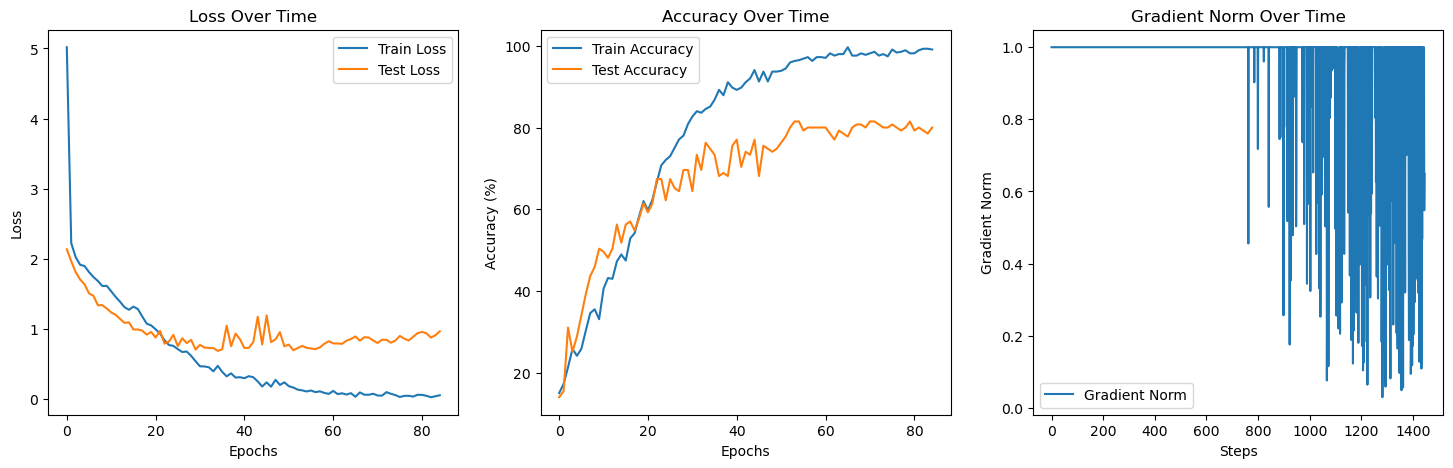

In [23]:
def train_model(model, train_loader, test_loader, num_epochs=20, learning_rate=0.001, weight_decay=1e-5, grad_clip_value=1.0, max_grad_norm=5.0, patience=10, device='cpu', lr_step_size=50, lr_gamma=0.1):
    # Loss function and optimizer with weight decay
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # LR scheduler (decays the learning rate every lr_step_size epochs by lr_gamma)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)

    # Early stopping variables
    best_test_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False

    # Lists to store loss, accuracy, and gradient norm
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    grad_norms = []

    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()

            # Gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip_value)

            # Calculate gradient norm for tracking
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            grad_norms.append(total_norm)

            # Check if the gradient norm exceeds the maximum allowed value
            if total_norm > max_grad_norm:
                print(f"Warning: Gradient norm {total_norm:.2f} exceeded max threshold {max_grad_norm}")

            # Optimizer step
            optimizer.step()

            # Update training loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100.0 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Testing loop
        model.eval()
        running_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Update test loss and accuracy
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total_test += labels.size(0)
                correct_test += predicted.eq(labels).sum().item()

        test_loss = running_loss / len(test_loader)
        test_accuracy = 100.0 * correct_test / total_test
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Step the learning rate scheduler
        scheduler.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, '
              f'Gradient Norm: {total_norm:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

        # Early stopping check
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs with patience {patience}.")
            early_stop = True

        if early_stop:
            break

    # Plotting loss
    plt.figure(figsize=(18, 5))
    
    # Loss Plot
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Time')

    # Accuracy Plot
    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Over Time')

    # Gradient Norm Plot
    plt.subplot(1, 3, 3)
    plt.plot(grad_norms, label='Gradient Norm')
    plt.xlabel('Steps')
    plt.ylabel('Gradient Norm')
    plt.legend()
    plt.title('Gradient Norm Over Time')

    plt.show()

# Initialize the model with 8 classes
num_classes = 8
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = MelSpectrogramCNN(num_classes=num_classes)

# Call the training loop with gradient norm tracking, early stopping, and LR scheduler
train_model(model, train_dataloader, test_dataloader, num_epochs=200, learning_rate=0.001, weight_decay=1e-5, grad_clip_value=1.0, max_grad_norm=5.0, patience=50, device=device, lr_step_size=50, lr_gamma=0.1)

# Classifying over whole dataset, mixed with normal intensity

In [25]:
csv_file = 'encoded_labels.csv'
df = pd.read_csv(csv_file)


train_df, test_df = train_test_split(df, test_size=0.2, stratify=df[['Emotion Encoded', 'Gender']], random_state=42)

train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

len(train_df),len(test_df)

(1152, 288)

In [26]:
train_file = "train_data.csv"
test_file = "test_data.csv"

image_folder = 'output_spectrograms'

train_dataset = MelSpectrogramDataset(csv_file=train_file, image_folder=image_folder, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = MelSpectrogramDataset(csv_file=test_file, image_folder=image_folder, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for images, labels in train_dataloader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break

Batch of images shape: torch.Size([32, 3, 128, 128])
Batch of labels shape: torch.Size([32])


Epoch [1/200], Train Loss: 3.4024, Train Accuracy: 14.58%, Test Loss: 2.0808, Test Accuracy: 13.89%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [2/200], Train Loss: 2.1238, Train Accuracy: 14.15%, Test Loss: 2.0735, Test Accuracy: 14.24%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [3/200], Train Loss: 2.0872, Train Accuracy: 17.36%, Test Loss: 2.0130, Test Accuracy: 25.00%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [4/200], Train Loss: 2.0268, Train Accuracy: 21.79%, Test Loss: 1.9438, Test Accuracy: 23.26%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [5/200], Train Loss: 1.9060, Train Accuracy: 25.43%, Test Loss: 1.7658, Test Accuracy: 32.29%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [6/200], Train Loss: 1.8164, Train Accuracy: 28.82%, Test Loss: 1.7097, Test Accuracy: 35.07%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [7/200], Train Loss: 1.7402, Train Accuracy: 32.81%, Test Loss: 1.5751, Test Accuracy: 37.50%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [8/200], Train Loss: 1.6612, Train 

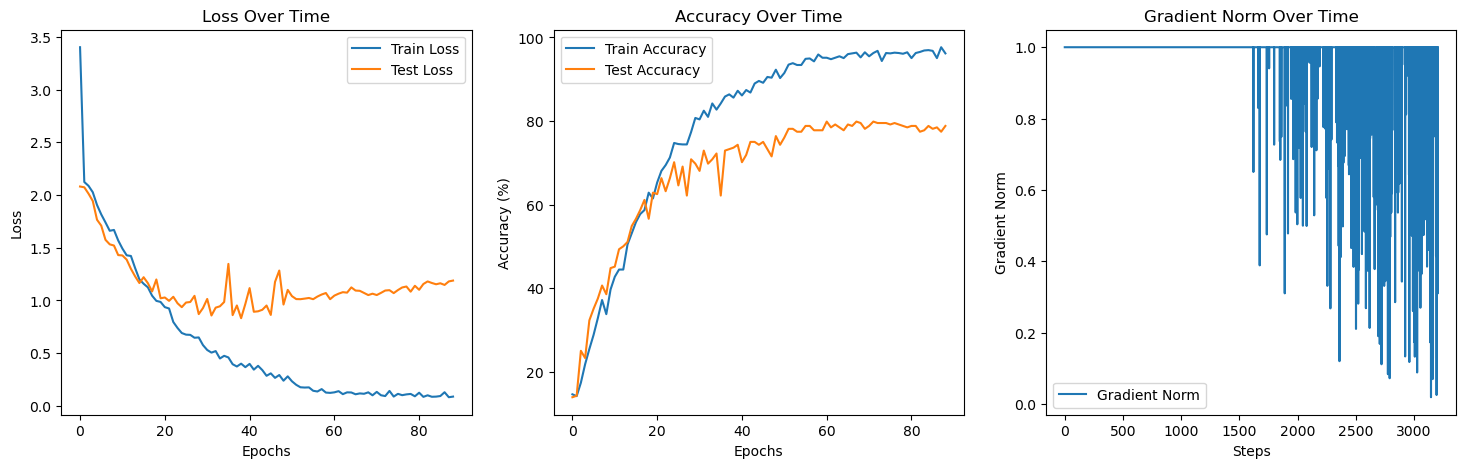

In [27]:
num_classes = 8
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = MelSpectrogramCNN(num_classes=num_classes)

# Call the training loop with gradient norm tracking, early stopping, and LR scheduler
train_model(model, train_dataloader, test_dataloader, num_epochs=200, learning_rate=0.001, weight_decay=1e-5, grad_clip_value=1.0, max_grad_norm=5.0, patience=50, device=device, lr_step_size=50, lr_gamma=0.1)

I dont think so there is need of categorical classification, as even without it model achieves almost same accuracy as using data from just one category

# Trying Transfer learning
checking if resnet can extract features of mel spectogram

In [28]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing the image to the size expected by the model
    transforms.ToTensor(),          # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])
train_file = "train_data.csv"
test_file = "test_data.csv"

image_folder = 'output_spectrograms'

train_dataset = MelSpectrogramDataset(csv_file=train_file, image_folder=image_folder, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = MelSpectrogramDataset(csv_file=test_file, image_folder=image_folder, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for images, labels in train_dataloader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break

Batch of images shape: torch.Size([32, 3, 128, 128])
Batch of labels shape: torch.Size([32])


In [33]:
class ResNetEmotionClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetEmotionClassifier, self).__init__()
        # Load pre-trained ResNet50
        self.model = models.resnet50(pretrained=True)

        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False

        # Replace the fully connected layer with a new one (customized for num_classes)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)


In [36]:
# Initialize the model with 8 classes
num_classes = 8

# Use 'ResNet50' or 'VGG19' based on your choice
model = ResNetEmotionClassifier(num_classes=num_classes)
# or for VGG19:
# model = VGG19EmotionClassifier(num_classes=num_classes)

# Move model to device (GPU or CPU)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = model.to(device)

# Train the model (use the previously defined `train_model` function)
train_model(model, train_dataloader, test_dataloader, num_epochs=200, learning_rate=0.001, weight_decay=1e-5, grad_clip_value=1.0, max_grad_norm=5.0, patience=50, device=device, lr_step_size=50, lr_gamma=0.1)

Epoch [1/200], Train Loss: 1.9693, Train Accuracy: 25.43%, Test Loss: 1.7601, Test Accuracy: 36.81%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [2/200], Train Loss: 1.6025, Train Accuracy: 40.97%, Test Loss: 1.6951, Test Accuracy: 40.62%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [3/200], Train Loss: 1.4486, Train Accuracy: 48.18%, Test Loss: 1.5577, Test Accuracy: 40.97%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [4/200], Train Loss: 1.3591, Train Accuracy: 51.56%, Test Loss: 1.5674, Test Accuracy: 39.58%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [5/200], Train Loss: 1.2718, Train Accuracy: 54.17%, Test Loss: 1.5518, Test Accuracy: 44.44%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [6/200], Train Loss: 1.2014, Train Accuracy: 57.99%, Test Loss: 1.5815, Test Accuracy: 38.89%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [7/200], Train Loss: 1.1492, Train Accuracy: 59.90%, Test Loss: 1.6316, Test Accuracy: 40.62%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [8/200], Train Loss: 1.1073, Train 

KeyboardInterrupt: 

Wont work, resnet and vgg arent trained to extract features from mel spectogram

# Feature Engineering and simple NN

In [32]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        
        # Define fully connected layers
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        # Pass through fully connected layers with ReLU activations and dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x


In [30]:
csv_file = 'encoded_labels.csv'
df = pd.read_csv(csv_file)


train_df, test_df = train_test_split(df, test_size=0.2, stratify=df[['Emotion Encoded', 'Gender']], random_state=42)

train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

len(train_df),len(test_df)

(1152, 288)

In [31]:
train_file = "train_data.csv"
test_file = "test_data.csv"

image_folder = 'output_spectrograms'

train_dataset = MelSpectrogramDataset(csv_file=train_file, image_folder=image_folder, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = MelSpectrogramDataset(csv_file=test_file, image_folder=image_folder, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for images, labels in train_dataloader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break

Batch of images shape: torch.Size([32, 3, 128, 128])
Batch of labels shape: torch.Size([32])


In [33]:
num_classes = 8
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
input_size = 3 *128 *128
model = SimpleNN(input_size ,num_classes=num_classes)

# Call the training loop with gradient norm tracking, early stopping, and LR scheduler
train_model(model, train_dataloader, test_dataloader, num_epochs=200, learning_rate=0.001, weight_decay=1e-5, grad_clip_value=1.0, max_grad_norm=5.0, patience=50, device=device, lr_step_size=50, lr_gamma=0.1)

Epoch [1/200], Train Loss: 8.8189, Train Accuracy: 13.72%, Test Loss: 2.0799, Test Accuracy: 13.54%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [2/200], Train Loss: 2.2245, Train Accuracy: 13.02%, Test Loss: 2.0783, Test Accuracy: 13.54%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [3/200], Train Loss: 2.1396, Train Accuracy: 13.19%, Test Loss: 2.0770, Test Accuracy: 13.54%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [4/200], Train Loss: 2.0936, Train Accuracy: 13.37%, Test Loss: 2.0751, Test Accuracy: 13.54%, Gradient Norm: 0.2187, LR: 0.001000
Epoch [5/200], Train Loss: 2.1415, Train Accuracy: 13.19%, Test Loss: 2.0737, Test Accuracy: 13.54%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [6/200], Train Loss: 2.0914, Train Accuracy: 13.45%, Test Loss: 2.0723, Test Accuracy: 13.54%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [7/200], Train Loss: 2.0732, Train Accuracy: 13.37%, Test Loss: 2.0711, Test Accuracy: 13.54%, Gradient Norm: 1.0000, LR: 0.001000
Epoch [8/200], Train Loss: 2.1006, Train 

KeyboardInterrupt: 

# Checking if without converting to frequncy domain would dl yield results

In [7]:
csv_file = 'actor_files.csv'
df = pd.read_csv(csv_file)

emotion_mapping = {
    'neutral': 0, 
    'calm': 1, 
    'happy': 2, 
    'sad': 3, 
    'angry': 4, 
    'fearful': 5, 
    'disgust': 6, 
    'surprised': 7
}

df['Emotion'] = df['Emotion'].replace(emotion_mapping)

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df[['Emotion', 'Gender']], random_state=42)


train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

len(train_df),len(test_df)

(1152, 288)

In [8]:
train_df

,File Path,Modality,Vocal Channel,Emotion,Emotional Intensity,Statement,Repetition,Actor,Gender
1322,archive/Actor_01/03-01-05-01-02-01-01.wav,audio-only,speech,4,normal,Dogs are sitting by the door,1,1,Male
169,archive/Actor_18/03-01-03-02-02-02-18.wav,audio-only,speech,2,strong,Dogs are sitting by the door,2,18,Female
1015,archive/Actor_22/03-01-01-01-02-02-22.wav,audio-only,speech,0,normal,Dogs are sitting by the door,2,22,Female
221,archive/Actor_20/03-01-04-01-02-01-20.wav,audio-only,speech,3,normal,Dogs are sitting by the door,1,20,Female
122,archive/Actor_18/03-01-02-02-02-01-18.wav,audio-only,speech,1,strong,Dogs are sitting by the door,1,18,Female
...,...,...,...,...,...,...,...,...,...
920,archive/Actor_24/03-01-04-01-01-01-24.wav,audio-only,speech,3,normal,Kids are talking by the door,1,24,Female
1047,archive/Actor_14/03-01-06-02-02-01-14.wav,audio-only,speech,5,strong,Dogs are sitting by the door,1,14,Female
1003,archive/Actor_22/03-01-08-01-02-02-22.wav,audio-only,speech,7,normal,Dogs are sitting by the door,2,22,Female
1258,archive/Actor_07/03-01-06-01-01-02-07.wav,audio-only,speech,5,normal,Kids are talking by the door,2,7,Male


In [12]:
class AudioDataset(Dataset):
    def __init__(self, dataframe, target_length=16000, sequence_length=400, overlap=200):
        self.dataframe = dataframe
        self.target_length = target_length
        self.sequence_length = sequence_length
        self.overlap = overlap

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the file path and label
        file_path = self.dataframe.iloc[idx]['File Path']
        emotion = self.dataframe.iloc[idx]['Emotion']

        # Load the audio file
        waveform, sample_rate = torchaudio.load(file_path)

        # Convert to a numpy array and normalize
        waveform = waveform.numpy()[0]  # Get first channel and convert to 1D array
        waveform = waveform.astype(np.float32)

        # Pad or truncate the waveform to the target length
        if len(waveform) < self.target_length:
            # Pad with zeros if the waveform is shorter than the target length
            waveform = np.pad(waveform, (0, self.target_length - len(waveform)), mode='constant')
        else:
            # Truncate if the waveform is longer than the target length
            waveform = waveform[:self.target_length]

        # Create sequences of size sequence_length with overlap
        sequences = []
        for start in range(0, self.target_length - self.sequence_length + 1, self.sequence_length - self.overlap):
            sequence = waveform[start:start + self.sequence_length]
            sequences.append(sequence)

        return torch.tensor(sequences), emotion  # Returning sequences and emotion


# Create the dataset
target_length = 16000  # Set the target length for the waveforms (e.g., 1 second at 16kHz)
train_audio_dataset = AudioDataset(dataframe=train_df, target_length=target_length, sequence_length=400, overlap=200)

# Create a DataLoader
batch_size = 32  # Adjust as necessary
train_audio_dataloader = DataLoader(train_audio_dataset, batch_size=batch_size, shuffle=True)

test_audio_dataset = AudioDataset(dataframe=test_df, target_length=target_length, sequence_length=400, overlap=200)
test_audio_dataloader = DataLoader(test_audio_dataset, batch_size=batch_size, shuffle=True)

# Example usage
for sequences, emotions in train_audio_dataloader:
    print(sequences.shape)  
    print(emotions.shape)   
    break

torch.Size([32, 79, 400])
torch.Size([32])


In [13]:
class AudioRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(AudioRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate the RNN
        rnn_out, _ = self.rnn(x, h0)  # rnn_out shape: (batch_size, num_sequences, hidden_size)
        
        # We use the last hidden state of the RNN sequence for classification
        out = self.fc(rnn_out[:, -1, :])  # Use the last output (of the last sequence)
        return out

In [18]:
def train_rnn_model(model, train_loader, test_loader, num_epochs=20, learning_rate=0.001, device='cpu'):
    # Set loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to store loss and accuracy values
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass through the RNN
            outputs = model(sequences)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track loss
            running_loss += loss.item()

            # Track accuracy
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        # Calculate average training loss and accuracy for the epoch
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100.0 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Testing loop
        model.eval()  # Set the model to evaluation mode
        running_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for sequences, labels in test_loader:
                sequences, labels = sequences.to(device), labels.to(device)

                # Forward pass through the RNN
                outputs = model(sequences)
                loss = criterion(outputs, labels)

                # Track loss
                running_loss += loss.item()

                # Track accuracy
                _, predicted = outputs.max(1)
                total_test += labels.size(0)
                correct_test += predicted.eq(labels).sum().item()

        # Calculate average test loss and accuracy for the epoch
        test_loss = running_loss / len(test_loader)
        test_accuracy = 100.0 * correct_test / total_test
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Print progress after every epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Plot loss over epochs
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Time')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Over Time')

    plt.show()

# Initialize the RNN model
input_size = 400  # Sequence length (features per time step)
hidden_size = 128  # Number of hidden units in the RNN
num_layers = 1     # Number of RNN layers
num_classes = 8    

model = AudioRNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = model.to(device)
# Train the model
train_rnn_model(model, train_audio_dataloader, test_audio_dataloader, num_epochs=100, learning_rate=0.001, device='cpu')

Epoch [1/100], Train Loss: 2.0722, Train Accuracy: 12.76%, Test Loss: 2.0651, Test Accuracy: 13.19%
Epoch [2/100], Train Loss: 2.0653, Train Accuracy: 11.28%, Test Loss: 2.0638, Test Accuracy: 13.19%
Epoch [3/100], Train Loss: 2.0639, Train Accuracy: 12.15%, Test Loss: 2.0636, Test Accuracy: 13.19%
Epoch [4/100], Train Loss: 2.0624, Train Accuracy: 12.67%, Test Loss: 2.0632, Test Accuracy: 13.19%
Epoch [5/100], Train Loss: 2.0633, Train Accuracy: 12.50%, Test Loss: 2.0634, Test Accuracy: 13.89%
Epoch [6/100], Train Loss: 2.0614, Train Accuracy: 12.41%, Test Loss: 2.0635, Test Accuracy: 13.19%
Epoch [7/100], Train Loss: 2.0607, Train Accuracy: 12.67%, Test Loss: 2.0632, Test Accuracy: 13.54%
Epoch [8/100], Train Loss: 2.0610, Train Accuracy: 13.80%, Test Loss: 2.0633, Test Accuracy: 13.54%
Epoch [9/100], Train Loss: 2.0597, Train Accuracy: 13.45%, Test Loss: 2.0638, Test Accuracy: 13.19%
Epoch [10/100], Train Loss: 2.0604, Train Accuracy: 12.85%, Test Loss: 2.0632, Test Accuracy: 14.58%

KeyboardInterrupt: 

# Would adding extra layers to an RNN help?
no, a single layer RNN is already designed to keep context, nor there is need for keeping some long term context

# Maybe Machine Learning models are the best performers? Or, do we just improve how we engineer the features?
Fourier transfrom is a complex funciton to be learnt by deep learning model, although theoratically it can converge to any function but would require some extra training and resources. Mel spectogram along with simple NN also didnt work although better feature engineering could be done and ml solutions can be further tried. My solution is converting sound signal to its components and converting into frequency domain of sound wave and learning features of mel spectogram through deep learning model, which according to me is better solution than using just feature enginnering and machine learning classifier or just using rnn for sequntial sound waves.

# Task 2

For clothes try ons, I ran multiple notebooks and hugging face models, for most tutorials or demos there were no customization options, so I just ran inferences and checked thier working flow.
https://colab.research.google.com/drive/1WfeKTPtt3qtlcTlrX47J03mxUzbVvyrL?usp=sharing#scrollTo=zFsP_R3MEooI
https://colab.research.google.com/drive/1fP5Wia4ukTp6WC5FlSa7InW7cOLXCePy?usp=sharing#scrollTo=Ojk__QBku3gD
# What novel application can we build around this Try-On?
For try ons, especially running inference over here https://huggingface.co/spaces/Nymbo/Virtual-Try-On, i think novelty would be model taking length and dimensions of person and clothes itself, as it turned short kameeze into model's kameeze size, to see how would clothes fit. While running inference here https://huggingface.co/spaces/HumanAIGC/OutfitAnyone model tucked short kameeze in pants, like a shirt, showing there is gap in try ons for cultural specific dresses.
# What would be the easiest to build, sell and scale?
For a simple solution, I would say something like a model for generating masks (taking in dimensions of clothes and person can be tried), Like generation of mask given dress and model is already a soultion, if it can be tried with keeping dimensions in view, it can probably sell and get an edge and thus can be scaled further.
# If I were a customer, what would I want the performance to look like?
Custommization, for that maybe some diffusion techniques which can also take text prompts for further customizations. For simple perfomance, I dont just wanna know how something would look on me but also how fit it would be on me, that would also pervent model from converging on cultural specific clothes biases.

![img](image.png)

![img](image.webp)

* Note: Code has been generated by gpt mostly. For each module, template was generated while specifc changes were done to solve problem.
*  A friend had worked in speech domain, my audios werent loading so help was taken to solve dependency issues of torchaudio.
* Tried try ons for first time, asked some friends for some working solutions whith playground to alter some code and do some experiments but couldnt find such playground demos for these models.